# Networks of Co-Occurrent Topic Modeling Terms 
# in Sufi Masterpaths

## by Moses A. Boudourides & Jeremy E. Farrell

## <span style="color:red">PART A</span>

In [1]:
import time
start_time = time.perf_counter()
import urllib, os, codecs, random, operator, re, string, copy, dateutil.parser, itertools, pickle, datetime, math, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, networkx as nx
import pygraphviz
from networkx.drawing.nx_agraph import graphviz_layout
from collections import Counter
from string import punctuation, digits
# import pathlib
# import spacy
# from spacy import displacy
# nlp = spacy.load('en_core_web_lg')
# import inflect
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from textblob import TextBlob
from nltk.stem.porter import *
stemmer = PorterStemmer()
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk import word_tokenize

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.corpora import Dictionary

import pyLDAvis
from pyLDAvis import gensim as pgensim
pyLDAvis.enable_notebook()

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.simplefilter('ignore')

### Load Data

In [2]:
name = "Sufi Masterpaths"

df = pd.read_csv('sufi_masterpaths.csv',encoding="utf-8")
print(len(df))
df.head()

2313


,Account,Author,Book,Text,T1,T2,T3,T4,T5,T6,T7,T8,T9,T10,T11,T12
0,SUFI_0001,Muḥammad b. al-Ḥusayn al-Burjulānī,KJSN_01,إنّما بعثت لأتمّم صالح الأخلاق,Saʿīd b. Manṣūr,ʿAbd al-ʿAzīz b. Muḥammad al-Azdī,ʿUbayd Allāh b. Shumayṭ b. ʿAjlān al-Qurashī,al-Qaʿqa b. Ḥakīm al-Kinānī al-Madanī,Abū Ṣāliḥ Dhakwān al-Sammān,Abū Hurayrah,Prophet_Muḥammad,NaN,NaN,NaN,NaN,NaN
1,SUFI_0002,Muḥammad b. al-Ḥusayn al-Burjulānī,KJSN_02,كان نبيّ اللّه أشدّ حياءً من جارية عذراء في خ...,Rawḥ b. ʿUbādah,Shuʿba b. al-Ḥajjāj,Qatādah,ʿAbd Allāh b. Abī ʿUtbah al-Baṣrī,Abū Saʿīd al-Khudarī,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,SUFI_0003,Muḥammad b. al-Ḥusayn al-Burjulānī,KJSN_03,لا يواجه أحداً في وجهه بشيء يكرهه,Sulaymān b. Ḥarb,Ḥammād,Salm al-ʿAlawī,Anas b. Mālik,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,SUFI_0004,Muḥammad b. al-Ḥusayn al-Burjulānī,KJSN_04,يا أمّ المؤمنين كيف كان خلق رسول اللّه صلّى ال...,Khālid b. Yazīd al-Qarnī,Jaʿfar b. Sulaymān al-Ḍubaʿī,Abū ʿImrān al-Jawnī,Yazīd b. Bābanūs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SUFI_0005,Muḥammad b. al-Ḥusayn al-Burjulānī,KJSN_05,كيف كان رسول اللّه صلّى الله عليه وسلّم إذا خل...,Yaḥyā b. Abī Bukayr,Mūsā b. Muḥammad al-Anṣārī,Ḥārithah b. Abī al-Rijāl,ʿAmrah bt. ʿAbd al-Raḥmān,ʿĀʾishah,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
authors=sorted(set(df['Author'].tolist()))
print(len(authors))
authors

9


['Abū Isḥāq Ibrāhīm b. ʿAbd Allāh b. al-Junayd al-Baghdādī al-Khuttalī',
 'Abū Saʿd Aḥmad b. Muḥammad al-Mālīnī',
 'Abū Saʿīd Muḥammad b. ʿAlī b. Naqqāsh',
 'Abū Saʿīd b. al-Aʿrābī',
 'Abū ʿAbd al-Raḥmān al-Sulamī',
 'Abū\xa0ʿAbd al-Raḥmān al-Sulamī',
 'Jaʿfar al-Khuldī',
 'Muḥammad b. al-Ḥusayn al-Burjulānī',
 'b. Ḥamakān al-Shāfiʿī']

In [4]:
docs_d={}
for a in authors:
    t=""
    for i in range(len(df)):
        if a==df.iloc[i]["Author"]:
            t+=df.iloc[i]["Text"]+" "
    docs_d[a]=t
print(len(docs_d))
docs=list(docs_d.values())
print(len(docs))
docs

9
9


['أحبوا الله عز وجل لما يغذوكم به من نعمه وأحبوني لحب الله عز وجل وأحبوا أهل بيتي لحبي أحبوا من أحب الله أحبوا الله من كل قلوبكم ولا تملوا كلام الله عز وجل ولا تقسون عليه قلوبكم ذكر النعم يورث المحبة  حب الله تعالى يضني الأبدان ويورث الطاعة من علامة المحب لله عز وجل دوام الذكر بالقلب واللسان وقل ما ولع المرء بذكر الله تعالى إلا أفاد منه حب الله عز وجل  تجدد ذكر الموت يحلق من القلب ما سواه ويحيي القلوب الميتة إيثار محبة الله على محبتك من علامة حبك لله عز وجل المحب لله عز وجل لا يجد مع حب الله عز وجل للدنيا لذة ولا يغفل عن ذكر الله طرفة الإيمان في قلب الرجل أن يحب الله عز وجل إن المؤمن الخالص إيمانه لا يحب كحبه الله عز وجل أحداً ولا يخشى كخشية الله عز وجل أحداً فإنه يعلم علماً يقيناً أن الخلق كله لله عز وجل وبيد الله وكان الله تعالى أهل ذلك منهم في القدرة عليهم والنعمة والبلاء الحسنين عندهم رأس الإيمان المحبة لله عز وجل وفي الله وسنام الإيمان البر والعدل وتحقيق الإيمان إكرام ذي الدين وذي الشيبة ومن لم يرحم صغيراً ويجل كبيراً فليس منا بسم الله وبه بدينا ولو عبدنا غيره شقينا حبذا رباً وحب 

In [5]:
excluded = stopwords.words('arabic') #+ list(punctuation) 

def tokenize(text):
    words = word_tokenize(text)
    words = [w.lower() for w in words]
    return [w for w in words if w not in excluded and not w.isdigit()] #stop_words

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS: # and len(token) > 3:
            result.append(token)
    return result

vocabulary = set()
for i in docs:
    words = tokenize(i)
    vocabulary.update(words)
 
vocabulary = list(vocabulary)
word_index = {w: idx for idx, w in enumerate(vocabulary)}
 
VOCABULARY_SIZE = len(vocabulary)
DOCUMENTS_COUNT = len(docs)
 
print(VOCABULARY_SIZE, DOCUMENTS_COUNT)

16100 9


In [6]:
excl=[]
# processed_docs = ppdocs #[preprocess(doc) for doc in documents]
processed_docs = [preprocess(doc) for doc in docs]
processed_docs1=[]
for x in processed_docs:
    y=[]
    for xx in x:
        if xx not in excl:
            y.append(xx)
    processed_docs1.append(y)
processed_docs=processed_docs1
allw=[]
for x in processed_docs:
    for xx in x:
        if xx not in allw:
            allw.append(xx)
print(len(allw)) #All 5752
# processed_docs[:10]

15416


In [7]:
allws=[]
for z in processed_docs:
    for zz in z:
        allws.append(zz)
print(len(allws),len(set(allws)))
# sorted(allws)
allwd=Counter(allws)
print(len(allwd))
# for p,q in allwd.items():
#     print(p,q)
# count = 0
# for k in sorted(allwd.keys()):
#     print(k)
#     count += 1
#     if count > 50:
#         break

62878 15416
15416


In [8]:
dictionary = gensim.corpora.Dictionary(processed_docs)
print(len(dictionary)) #All 32368
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break

15416
0 آت
1 آتيتكم
2 آثر
3 آثروا
4 آخر
5 آخره
6 آدم
7 آذاه
8 آمر
9 آمنوا
10 آمين


In [9]:
dictionary.filter_extremes(no_below=5, no_above=0.7) #, keep_n=300) # 5
len(dictionary) 

319

In [10]:
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]
# bow_corpus[43]

#### Detecting "Optimal" Number of Topics

#### <span style="color:red">The minimum number of topics below (mint) should be at least 2 or 3.</span>

In [11]:
# mint = 3  # minimum number of topics
# maxt = 11 # maximum number of topics
# m=30
# X = range(mint,maxt)
# Y = []
# for n in X:
#     ft=[]
#     for j in range(m):
#         lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=n, id2word=dictionary, passes=2, workers=2)
#     #     topics = lda_model.print_topics()
#         sss=[]
#         for idx, topic in lda_model.print_topics(-1):
#             tt=[]
#             s=topic.split(" + ")
#             ss=[]
#             uu=[]
#             for t in s:
#                 u0=float(t.split("*")[0])
#                 u1=t.split("*")[1].replace('"','')
#                 if (u1,u0) not in ss:
#                     ss.append((u1,u0))
#                 if t not in uu:
#                     uu.append(t) 
#             sss.append(ss)
#             topic=" + ".join(uu).encode('utf-8')
#         doms=[]
#         for i in sss:
#             doms.append(i[0][0])
#         fi=len(set(doms))/n
#         ft.append(fi)
#     fis=sum(ft)/m
#     Y.append(fis)
# # print(list(X))
# print(Y)
# nn=[]
# for i,y in enumerate(Y):
#     if y==max(Y): #1:
#         print(Y.index(y))
#         nn.append(i)
# print(nn)
# NT=nn[-1]+mint
# print(NT)

In [12]:
nt=4 #NT #number_of_topics
lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=nt, id2word=dictionary, passes=2, workers=2)

In [13]:
topics = lda_model.print_topics() #350  #num_words=25

terms=[]
lt=[]
for i in range(nt):
    for t in topics: 
        lt.append(t[1].split(" + "))
for s in lt:
    for ss in s:
        terms.append(ss[6:])
#         if re.sub(r'[^a-zA-Z]','', ss) not in terms:
#             terms.append(re.sub(r'[^a-zA-Z]','', ss))
terms=[t.replace('"',"") for t in terms]
terms=sorted(set(terms))
print(len(terms))
print(" ")
print("LIST OF TOPIC MODELING TERMS:")
print(" ")
for i in terms:
    print(i)

26
 
LIST OF TOPIC MODELING TERMS:
 
إل
الت
الحق
الدنيا
الذي
الصلاة
المحب
الناس
بالل
بعض
بما
ثلاثا
سمعت
سنة
عليهم
غير
فمن
فهو
قالت
قط
لأن
لام
محم
نيا
والل
وسلم


In [14]:
sss=[]
for idx, topic in lda_model.print_topics(-1):
    tt=[]
    s=topic.split(" + ")
    ss=[]
    uu=[]
    for t in s:
        u0=float(t.split("*")[0])
        u1=t.split("*")[1].replace('"','')
        if (u1,u0) not in ss:
            ss.append((u1,u0))
        if t not in uu:
            uu.append(t) 
    sss.append(ss)
    topic=" + ".join(uu).encode('utf-8')
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: b'0.028*"\xd8\xa5\xd9\x84" + 0.014*"\xd9\x84\xd8\xa7\xd9\x85" + 0.013*"\xd8\xab\xd9\x84\xd8\xa7\xd8\xab\xd8\xa7" + 0.013*"\xd8\xa7\xd9\x84\xd9\x86\xd8\xa7\xd8\xb3" + 0.012*"\xd9\x82\xd8\xa7\xd9\x84\xd8\xaa" + 0.011*"\xd9\x86\xd9\x8a\xd8\xa7" + 0.010*"\xd9\x82\xd8\xb7" + 0.010*"\xd8\xa7\xd9\x84\xd8\xb5\xd9\x84\xd8\xa7\xd8\xa9" + 0.009*"\xd9\x88\xd8\xa7\xd9\x84\xd9\x84" + 0.009*"\xd8\xa7\xd9\x84\xd8\xb0\xd9\x8a"'
Topic: 1 
Words: b'0.034*"\xd9\x86\xd9\x8a\xd8\xa7" + 0.033*"\xd8\xa5\xd9\x84" + 0.026*"\xd8\xa7\xd9\x84\xd8\xaa" + 0.023*"\xd8\xa7\xd9\x84\xd8\xad\xd9\x82" + 0.014*"\xd8\xa8\xd8\xa7\xd9\x84\xd9\x84" + 0.013*"\xd9\x81\xd9\x87\xd9\x88" + 0.013*"\xd8\xba\xd9\x8a\xd8\xb1" + 0.012*"\xd9\x84\xd8\xa3\xd9\x86" + 0.012*"\xd9\x81\xd9\x85\xd9\x86" + 0.011*"\xd8\xa8\xd9\x85\xd8\xa7"'
Topic: 2 
Words: b'0.021*"\xd8\xa7\xd9\x84\xd8\xaf\xd9\x86\xd9\x8a\xd8\xa7" + 0.019*"\xd8\xa5\xd9\x84" + 0.016*"\xd8\xb3\xd9\x85\xd8\xb9\xd8\xaa" + 0.015*"\xd8\xa8\xd8\xb9\xd8\xb6" + 0.014*"\x

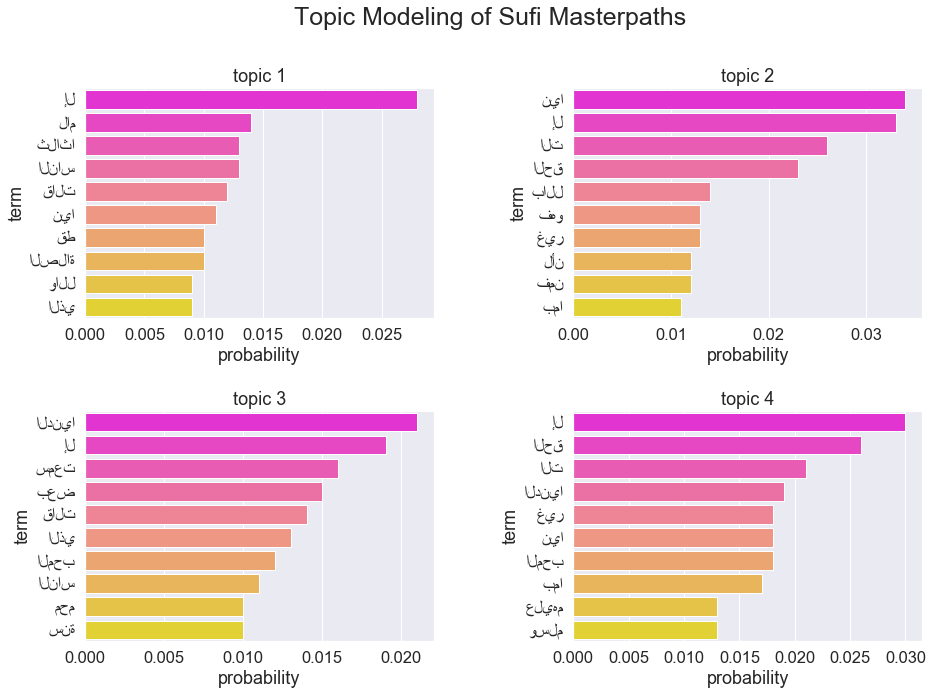

In [15]:
fig=plt.figure(figsize=(15,28)) #figsize=(15,2.4*15*((nt+1)/4))); #15
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(nt):
    sns.set(font_scale = 1.5)
    df=pd.DataFrame(sss[i], columns=['term','prob']).set_index('term')
#     plt.subplot(nt+1,2,i+1); #5
    ax = fig.add_subplot(nt+1,2,i+1)
    plt.title('topic '+str(i+1));
    sns.barplot(x='prob', y=df.index, data=df, label='Cities', palette='spring');
    plt.xlabel('probability');
sst="Topic Modeling of %s" %name
plt.suptitle(sst,fontsize=25, y=0.92);
plt.show()

In [16]:
from pyLDAvis import gensim as pgensim
vis = pgensim.prepare(lda_model,bow_corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.023293 -0.030247       1        1  36.514484
2     -0.002156  0.029720       2        1  23.814266
0     -0.058969 -0.007734       3        1  22.223442
3      0.037833  0.008262       4        1  17.447807, topic_info=    Category        Freq    Term       Total  loglift  logprob
35   Default   90.000000    الحق   90.000000  30.0000  30.0000
39   Default   66.000000  الدنيا   66.000000  29.0000  29.0000
50   Default   60.000000   المحب   60.000000  28.0000  28.0000
225  Default  104.000000     الت  104.000000  27.0000  27.0000
104  Default   41.000000    سمعت   41.000000  26.0000  26.0000
..       ...         ...     ...         ...      ...      ...
146   Topic4    6.772729    قلبك   28.891544   0.2953  -5.0839
134   Topic4    8.270333     فمن   46.836174   0.0120  -4.8841
136   Topic4    8.389798     فهو   50.570728  -0.0504  -4.8698
244   Topic4    7.400977    بالل   46.866909  -0.0997  -4.9952
140   Topic4    7.109715    قالت   52.656185  -0.2564  -5.0353

[227 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
305       1  0.273422   أتى
305       2  0.136711   أتى
305       3  0.546844   أتى
305       4  0.091141   أتى
1         1  0.177521  أتيت
...     ...       ...   ...
209       4  0.310702  يعلم
215       1  0.132459  يلقى
215       2  0.397377  يلقى
215       3  0.264918  يلقى
215       4  0.132459  يلقى

[573 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 4])

## <span style="color:red">PART B</span>

## The Network of Co-Occurrent Terms Derived from Topic Modeling

In [17]:
terms

['إل',
 'الت',
 'الحق',
 'الدنيا',
 'الذي',
 'الصلاة',
 'المحب',
 'الناس',
 'بالل',
 'بعض',
 'بما',
 'ثلاثا',
 'سمعت',
 'سنة',
 'عليهم',
 'غير',
 'فمن',
 'فهو',
 'قالت',
 'قط',
 'لأن',
 'لام',
 'محم',
 'نيا',
 'والل',
 'وسلم']

In [18]:
# pre=[]
# for i in range(len(terms)):
#     start=terms[i][:4]
#     pre.append(start)
# for j,k in Counter(pre).items():
#     if k>1:
#         print(j)

In [19]:
# # # When no alias dictionary is needed

# alias_dict={}
# for n in terms:
#     alias_dict[n]=n
    
# # # For the case you need to use an alias dictionary:

# # alias_dict={}
# # for n in terms:
# #     if n=="paper":
# #         alias_dict[n]="paper"
# #     elif n=="papers":
# #         alias_dict[n]="paper"
# #     elif n=="steps":
# #         alias_dict[n]="steps"
# #     elif n=="stepped":
# #         alias_dict[n]="steps"
# #     if n=="anxiety":
# #         alias_dict[n]="anxiety"
# #     elif n=="anxious":
# #         alias_dict[n]="anxiety"
# #     if n=="fall":
# #         alias_dict[n]="fall"
# #     elif n=="fallen":
# #         alias_dict[n]="falling"
# #     elif n=="falling":
# #         alias_dict[n]="falling"
# #     elif n=="laugh":
# #         alias_dict[n]="laugh"
# #     elif n=="laughed":
# #         alias_dict[n]="laugh"
# #     elif n=="spirit":
# #         alias_dict[n]="spirit"
# #     elif n=="spirits":
# #         alias_dict[n]="spirit"
# #     elif n=="tells":
# #         alias_dict[n]="telling"
# #     elif n=="telling":
# #         alias_dict[n]="telling"
# #     elif n=="wished":
# #         alias_dict[n]="wishes"
# #     elif n=="wishes":
# #         alias_dict[n]="wishes"
# #     else:
# #         alias_dict[n]=n

# print("The dictionary of aliases has %i keys (terms) and %i unique values (aliased terms)" %(len(alias_dict.keys()),len(set(alias_dict.values()))))
# # for k,v in alias_dict.items():
# #     print(k,"-->",v)

In [20]:
# tdocs=" ".join(docs)
# blob = TextBlob(tdocs)
# textSentences = blob.sentences
# sendic=dict()
# for i,v in enumerate(textSentences):
#     sent=v.sentiment.polarity
#     wl=[]
#     for term in terms: #list(set(alias_dict.values())):
#         if term in v: 
#             wl.append(term)
#     if len(wl)>1:
#         sendic[i]=wl 
# medges=[]
# for k,v in sendic.items():
#     print(k,v)
#     sent=textSentences[k].sentiment.polarity
#     dd={}
#     ps=set()
#     for j in itertools.combinations(v, 2):
#         ps.add(j)
#         dd[j]=k #(k,sent)
#     for jj in ps:
#         s=0
# #         ss=0
#         for kk,vv in dd.items():
#             if kk==jj:
#                 s+=1
# #                 ss+=vv[1]
#         if jj[0]!=jj[1]: #alias_dict[jj[0]]!=alias_dict[jj[1]]:
# #             medges.append((alias_dict[jj[0]],alias_dict[jj[1]],"Sentence_"+str(k),ss/float(s)))
#             medges.append((jj[0],jj[1],"Sentence_"+str(k))) #,ss/float(s)))
# print("%s contains %i sentential co-occurrences among %i unsupervized TM terms"%(name,len(medges),len(terms))) #len(set(alias_dict.values()))))
# medges

In [21]:
medges=[]
for k,v in docs_d.items():
    for j in itertools.combinations(terms, 2):
        if j[0] in v and j[1] in v:
            if j[0]!=j[1]:
                medges.append((j[0],j[1]))
print(len(medges),len(set(medges)))
print("%s contains %i co-occurrences among %i Topic Modeling terms"%(name,len(medges),len(terms))) #len(set(alias_dict.values()))))
medges

1818 325
Sufi Masterpaths contains 1818 co-occurrences among 26 Topic Modeling terms


[('إل', 'الت'),
 ('إل', 'الحق'),
 ('إل', 'الدنيا'),
 ('إل', 'الذي'),
 ('إل', 'الصلاة'),
 ('إل', 'المحب'),
 ('إل', 'الناس'),
 ('إل', 'بالل'),
 ('إل', 'بعض'),
 ('إل', 'بما'),
 ('إل', 'سمعت'),
 ('إل', 'سنة'),
 ('إل', 'عليهم'),
 ('إل', 'غير'),
 ('إل', 'فمن'),
 ('إل', 'فهو'),
 ('إل', 'قالت'),
 ('إل', 'قط'),
 ('إل', 'لأن'),
 ('إل', 'لام'),
 ('إل', 'محم'),
 ('إل', 'نيا'),
 ('إل', 'والل'),
 ('إل', 'وسلم'),
 ('الت', 'الحق'),
 ('الت', 'الدنيا'),
 ('الت', 'الذي'),
 ('الت', 'الصلاة'),
 ('الت', 'المحب'),
 ('الت', 'الناس'),
 ('الت', 'بالل'),
 ('الت', 'بعض'),
 ('الت', 'بما'),
 ('الت', 'سمعت'),
 ('الت', 'سنة'),
 ('الت', 'عليهم'),
 ('الت', 'غير'),
 ('الت', 'فمن'),
 ('الت', 'فهو'),
 ('الت', 'قالت'),
 ('الت', 'قط'),
 ('الت', 'لأن'),
 ('الت', 'لام'),
 ('الت', 'محم'),
 ('الت', 'نيا'),
 ('الت', 'والل'),
 ('الت', 'وسلم'),
 ('الحق', 'الدنيا'),
 ('الحق', 'الذي'),
 ('الحق', 'الصلاة'),
 ('الحق', 'المحب'),
 ('الحق', 'الناس'),
 ('الحق', 'بالل'),
 ('الحق', 'بعض'),
 ('الحق', 'بما'),
 ('الحق', 'سمعت'),
 ('الحق', 'سنة

In [22]:
# medgesd=[]
# for e in medges:
#     d={}
#     d['Sentence']=e[2]
#     d['Average sentiment']=e[3]
#     medgesd.append((e[0],e[1],d))
    
G = nx.MultiGraph()
G.add_edges_from(medges)
for e in G.edges(data=True):
    if e[0]==e[1]:
        G.remove_edge(e[0],e[1])
weight={(x,y):v for (x, y), v in Counter(G.edges()).items()}
w_edges=[(x,y,z) for (x,y),z in weight.items()]
Gw = nx.Graph()
Gw.add_weighted_edges_from(w_edges)

print("The graph of co-occurrent Topic Modeling terms in %s is a weighted graph and \n it has %i nodes and %i edges \n" %(name,len(Gw.nodes()),len(Gw.edges())))
# out=' '.join([n+"\n" for n in alias_dict.values() if n not in Gw.nodes()])
# print("The terms which do not co-occur in sentences are: \n %s" %out)
# # print "Graph Gw is a weighted graph with %i nodes and %i edges" %(len(Gw.nodes()),len(Gw.edges()))
print("The density of this graph is %.3f" %nx.density(Gw))
if nx.is_connected(Gw)==True:
    print ("This graph is a connected graph")
else:
    print ("This graph is a disconnected graph and it has",nx.number_connected_components(Gw),"connected components" )   
    giant = max(nx.connected_component_subgraphs(Gw), key=len)
    Gwlcc=Gw.subgraph(giant)
    print ("The largest connected component of this graph is a weighted graph with %i nodes and %i edges" %(len(Gwlcc.nodes()),len(Gwlcc.edges())))
    print ("The density of the largest connected component of this graph is %.3f" %nx.density(Gwlcc))

The graph of co-occurrent Topic Modeling terms in Sufi Masterpaths is a weighted graph and 
 it has 26 nodes and 325 edges 

The density of this graph is 1.000
This graph is a connected graph


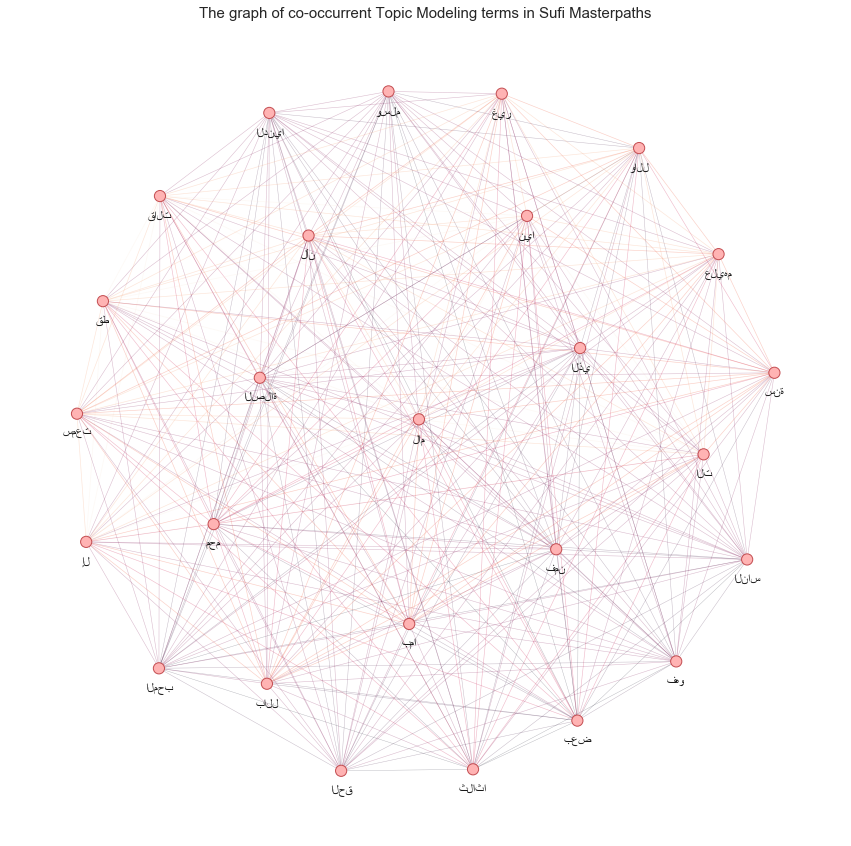

In [23]:
edge_width=[Gw[u][v]['weight'] for u,v in Gw.edges()]
edge_width=[0.3*math.log(1+w) for w in edge_width]
# cmap=plt.cm.cool
weight_list = [ e[2]['weight'] for e in Gw.edges(data=True) ]
edge_color=weight_list
# vmin = min(edge_color) 
# vmax = max(edge_color) 
# width_list=[2*math.log(2+w) for w in weight_list]
width_list=[1.5*math.log(abs(min(weight_list))+2+w) for w in weight_list] #weight_list
nsi=[5*Gw.degree(n) for n in Gw.nodes()]

figsize=(15,15)

pos=graphviz_layout(Gw) 
# pos=nx.spring_layout(Gw)

node_color="#ffb3b3"
node_border_color="r"
plt.figure(figsize=figsize);
nodes = nx.draw_networkx_nodes(Gw, pos, node_color=node_color,node_size=nsi)
nodes.set_edgecolor(node_border_color)
nx.draw_networkx_edges(Gw, pos, edge_color=edge_color,width=edge_width,alpha=0.3) #edge_cmap=cmap,vmin=vmin, vmax=vmax,
plt.axis('off');
yoffset = {}
y_off = -3 # offset on the y axis
for k, v in pos.items():
    yoffset[k] = (v[0], v[1]+y_off)
nx.draw_networkx_labels(Gw, yoffset,font_size=12);
# sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
# sm.set_array([])
# cbar = plt.colorbar(sm, orientation='horizontal', shrink=0.7, pad = 0.02)
# cbar.set_label('Average sentiment of sentences')
sst="The graph of co-occurrent Topic Modeling terms in %s" %name
plt.title(sst,fontsize=15);
plt.margins(x=0.1, y=0.1) 

In [24]:
print("Run in %.2f seconds (%.2f minutes)" %(time.clock() - start_time,(time.clock() - start_time)/60))

Run in 12.11 seconds (0.20 minutes)
